# Transportation Aircraft

In [1]:
import casadi as ca
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [3]:
# Constant Values given
S = 2170.0
CBAR = 17.5
MASS = 5 * 10**3
IYY = 4.1 * 10**6
TSTAT = 6.0 * 10**4
DTDV = -38.0
ZE = 2.0
CDCLS = 0.042
CLA = 0.085
CMA = -0.022
CMDE = -0.016
CMQ = -16.0
CMADOT = -6.0
CLADOT = 0.0
RTOD = 75.29578
GD = 32.17

In [4]:
THTL = ca.SX.sym('THTL')
ELEV = ca.SX.sym('ELEV')
XCG = ca.SX.sym('XCG')
LAND = ca.SX.sym('LAND')
TILT = ca.SX.sym('TILT')

u = ca.vertcat(THTL, ELEV, XCG, LAND, TILT)

VT = ca.SX.sym('VT')
ALPHA = ca.SX.sym('ALPHA')
THETA = ca.SX.sym('THETA')
Q = ca.SX.sym('Q')
H = ca.SX.sym('H')

x = ca.vertcat(VT, RTOD * ALPHA, THETA, Q, H)

In [5]:
MACH = ca.SX.sym('MACH')
QBAR = ca.SX.sym('QBAR')

In [6]:
# ADC Function
ADC = ca.Function('ADC', [VT, H], [MACH, QBAR])
R0 = 2.377 * 10**-3
TFAC = 1.0 - 0.703**-5 * H
T1 = 519.0 * TFAC
T2 = 390.0

Temp = ca.if_else(H >= 35000, T2, T1)

Rho = R0 * (TFAC**4.14)
Mach = VT / ((1.4*1716.3*Temp)**0.5)
QBAR = 0.5 * Rho * (VT**2)
C_PS = 1715.0 * Rho * Temp

In [7]:
MACH, QBAR = ADC(VT, H)

QS = QBAR * S
SALP = ca.sin(x[1])
CALP = ca.cos(x[1])
GAM = THETA - x[1]
SGAM = ca.sin(GAM)
CGAM = ca.cos(GAM)

In [8]:
LAND0 = (0.20,0.16,0.05,0.0,0.0)
LAND1 = (1.0,0.08,-0.20,0.02,-0.05)

coeff = ca.if_else(LAND, LAND1, LAND0)
CL0 = coeff[0]
CD0 = coeff[1]
CM0 = coeff[2]
DCDG = coeff[3]
DCMG = coeff[4]

In [9]:
THR = (TSTAT + VT * DTDV) * ca.fmax(THTL, 0)
CL = CL0 + CLA * ALPHA
CM = DCMG + CM0 + CMA * ALPHA + CMDE * ELEV + CL*(XCG-0.25)
CD = DCDG + CD0 + CDCLS * CL * CL

In [10]:
xd0 = (THR * CALP - QS * CD) / MASS - GD * SGAM
xd1 = (-THR * SALP - QS * CL + MASS * (VT * Q + GD * CGAM)) / (MASS * VT + QS * CLADOT)
xd2 = Q
D = 0.5 * CBAR * (CMQ*Q + CMADOT*xd1) / VT
xd3 = (QS * CBAR * (CM + D) + THR * ZE) / IYY
xd4 = VT * SGAM
xd5 = VT * CGAM

xd = ca.vertcat(xd0, xd1, xd2, xd3, xd4, xd5)

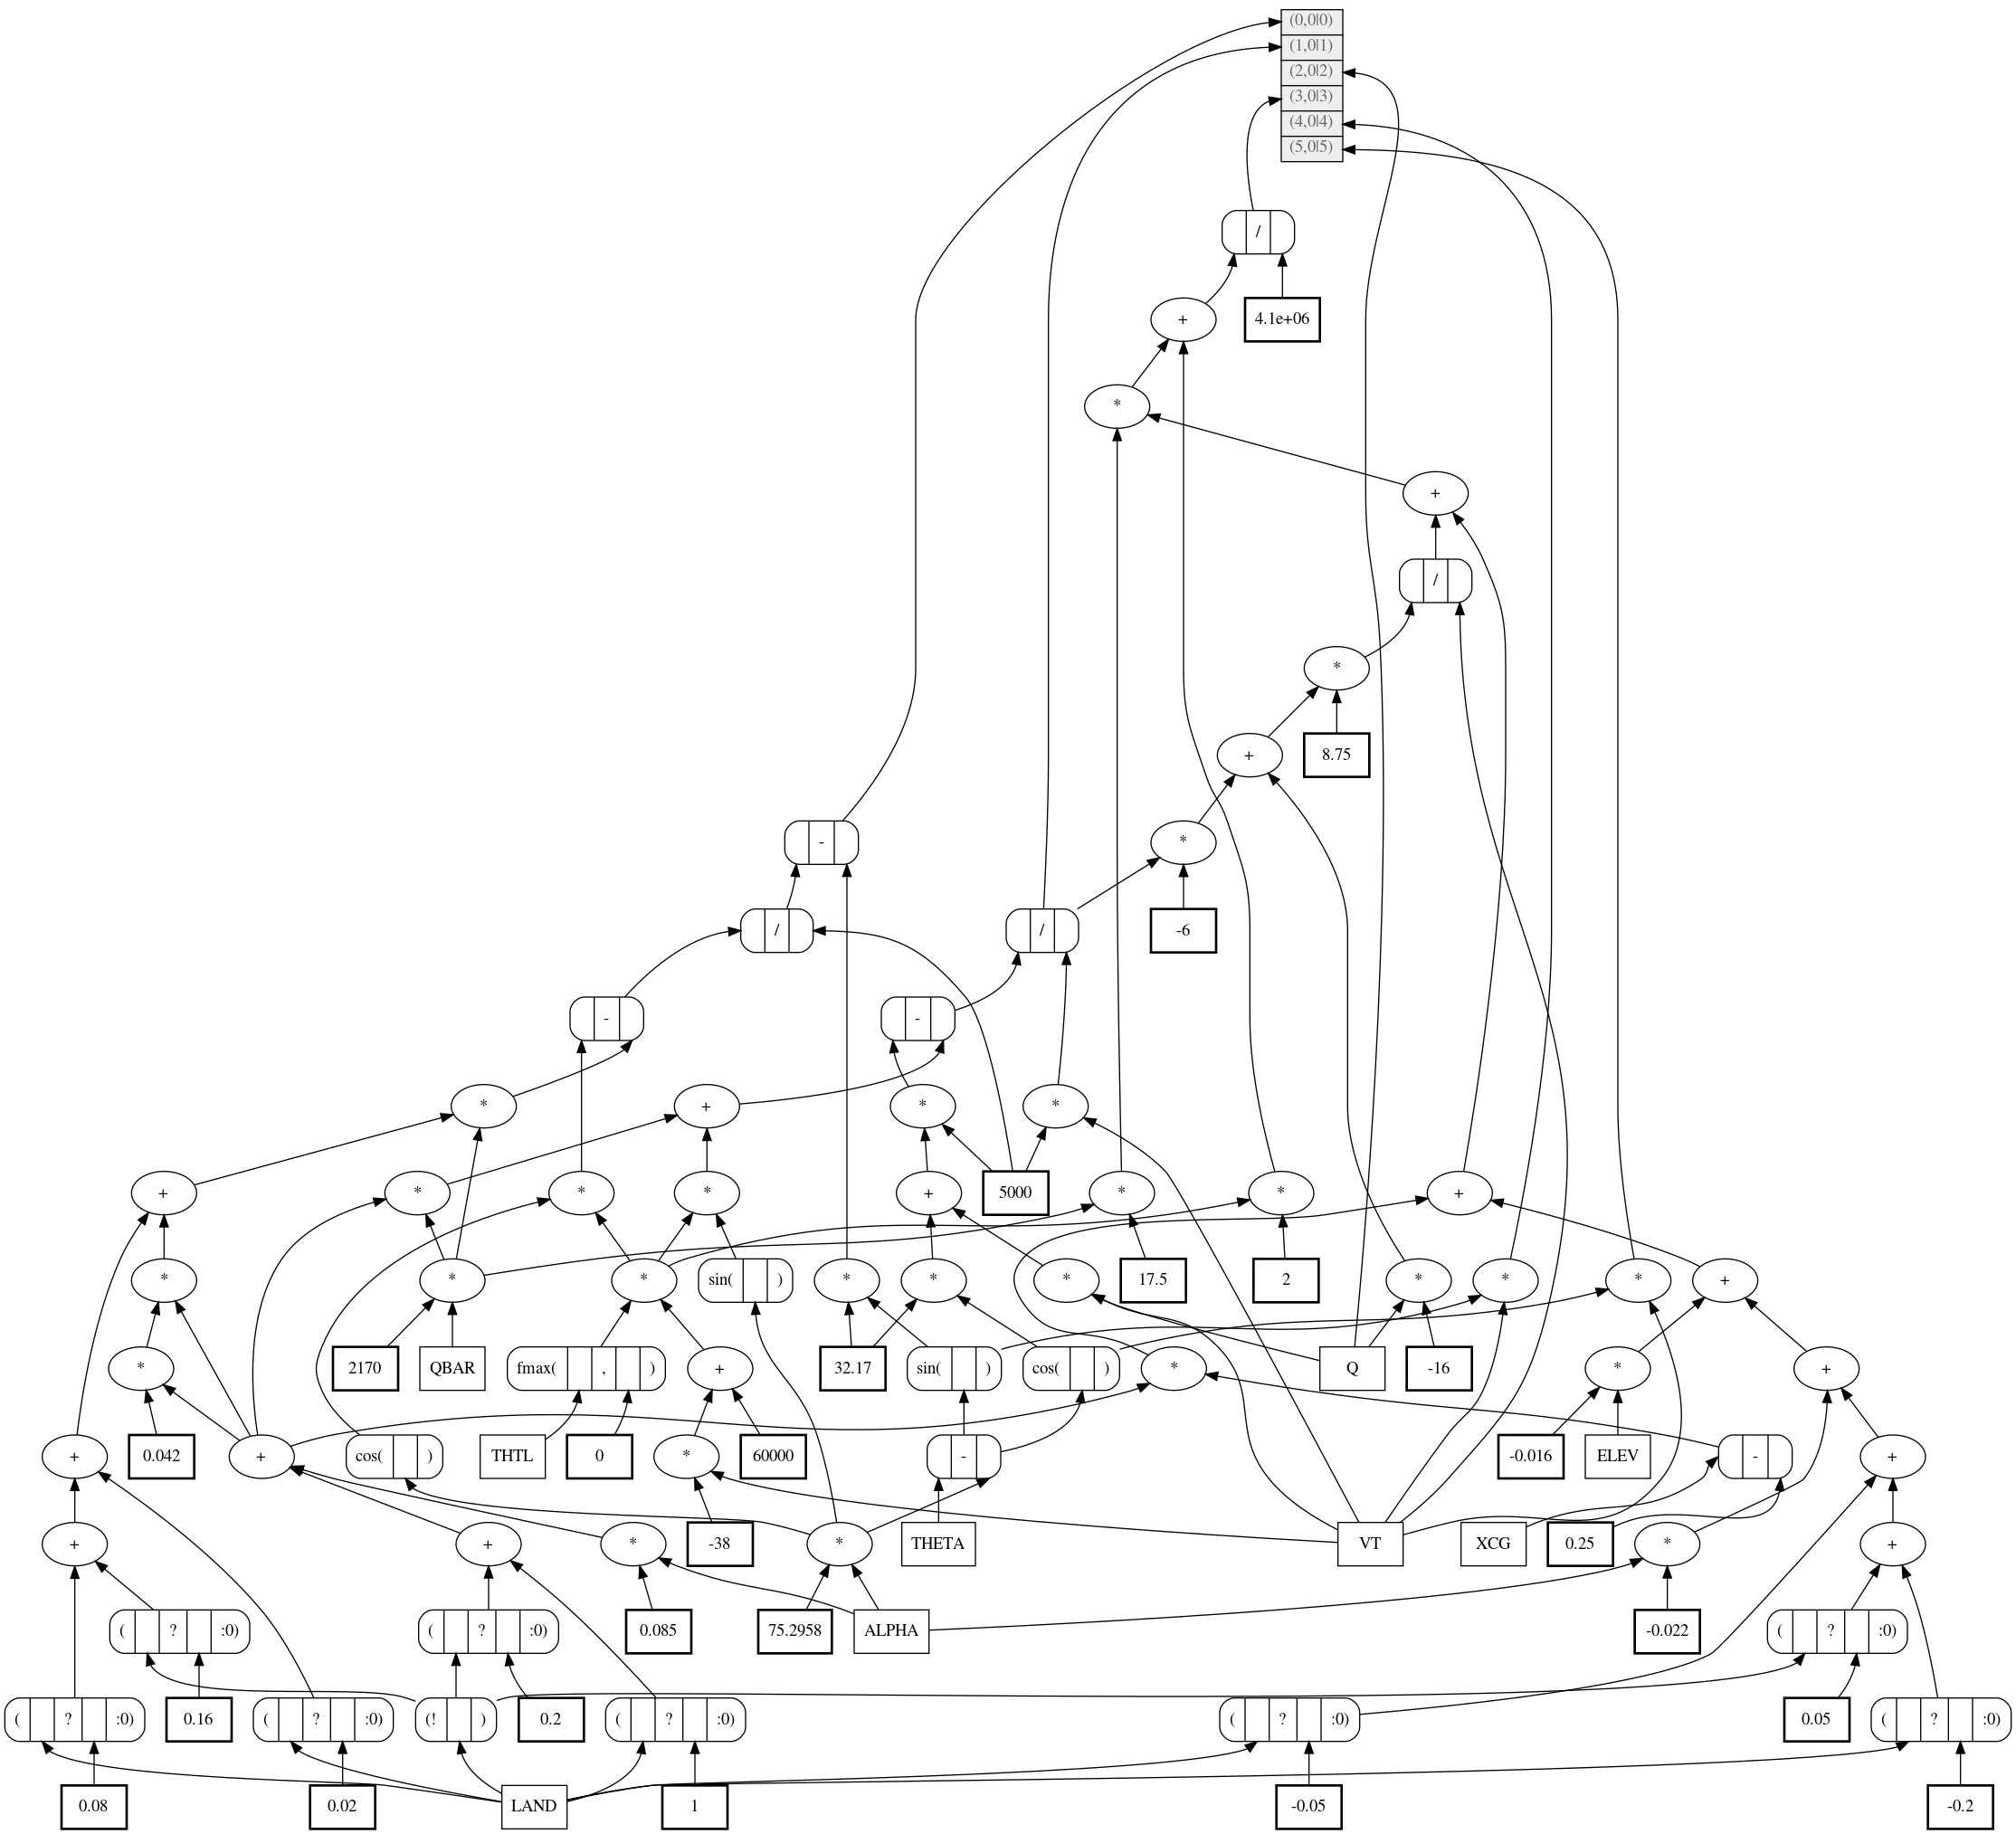

In [11]:
draw_graph(xd)